# Exam Paper 17th of january 2026

## 1 Danish House prices

### 1.1 Question 1

In [152]:
%pip install git+https://github.com/alemartinello/dstapi # Install the dstapi package from GitHub

  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/z7/tgkq7pjx7tvb8lys3k1y4ffw0000gn/T/pip-req-build-i9tkx68z
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/z7/tgkq7pjx7tvb8lys3k1y4ffw0000gn/T/pip-req-build-i9tkx68z
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [153]:
# Importing the necessary packages
import numpy as np
import pandas as pd

from dstapi import DstApi

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

In [154]:
# We can then define the data and display a summary of the contents
House_prices = DstApi('EJ56') 
House_prices.tablesummary(language='en')

Table EJ56: Price index for sales of property by region, category of real property, unit and time
Last update: 2026-01-08T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,17,000,All Denmark,11,Province Nordjylland,False
1,EJENDOMSKATE,3,0111,One-family houses,2103,"Owner-occupied flats, total",False
2,TAL,3,100,Index,310,Percentage change compared to same quarter the...,False
3,Tid,135,1992K1,1992Q1,2025K3,2025Q3,True


In [155]:
# Now we can download the data we need
params = {
    'table': 'EJ56',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        # With out relevant values
        {'code': 'TAL',   'values': ['100']},
        {'code': 'EJENDOMSKATE', 'values': ['*']},
        {'code': 'OMRÅDE',  'values': ['*']}, # Provinces
        {'code': 'TID',     'values': ['*']},  
    ]
}
HP = House_prices.get_data(params=params)

In [156]:
# We get an error when trying to convert the time periods to dates because of missing values
# So we first replace the missing values with NAN
HP['INDHOLD'] = HP['INDHOLD'].replace('..', pd.NA)

In [157]:
# Then we can convert the relevant columns to the appropriate data types

# Convert INDHOLD to numeric, coerce errors to NaN
HP['INDHOLD'] = pd.to_numeric(HP['INDHOLD'], errors='coerce')
HP['date'] = HP['TID'].apply( # convert time periods to end of quarter dates
    lambda x: pd.Period(str(x).replace('K', 'Q'), freq='Q').end_time
)

# Rename VALUE to INDHOLD if necessary
if 'INDHOLD' not in HP.columns and 'VALUE' in HP.columns:
    HP = HP.rename(columns={'VALUE': 'INDHOLD'})

HP['INDHOLD'] = HP['INDHOLD'].astype(float) # ensure INDHOLD is float
HP['year'] = HP['date'].dt.year # extract year from date
HP = HP.sort_values('date') # sort by date

# Drop unneeded columns
HP = HP.drop(columns=['TAL', 'EJENDOMSKATE', 'TID'])

In [158]:
# Now we compute the index with base 1992Q1

base_date = pd.Period('1992Q1', freq='Q').end_time

base = (
    HP.loc[HP['date'] == base_date]
      .groupby('OMRÅDE', as_index=False)['INDHOLD']
      .mean()
      .rename(columns={'INDHOLD': 'base_1992Q1'})
)

# then we merge the base values back to the original data and compute the index
HP2 = HP.merge(base, on='OMRÅDE', how='left')
HP2['INDEX_1992'] = HP2['INDHOLD'] / HP2['base_1992Q1'] * 100


In [159]:
# We create a pivot table to compute the index with base 1992Q1
wide = (
    HP2.pivot_table(
        index='date',
        columns='OMRÅDE',
        values='INDEX_1992',
        aggfunc='first'
    )
    .sort_index()
)

wide = wide.dropna(axis=1, how='any')

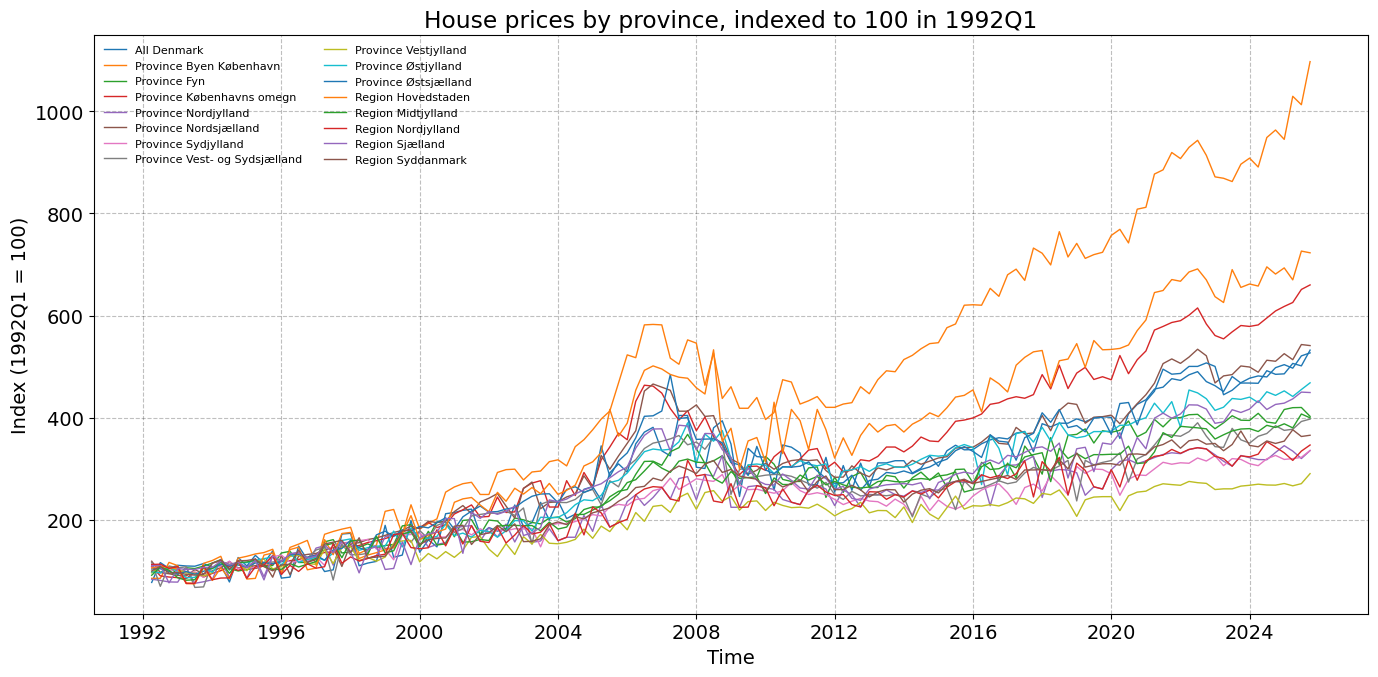

In [160]:
# lastly, we can plot the results
plt.figure(figsize=(14,7))
for c in wide.columns:
    plt.plot(wide.index, wide[c], linewidth=1)

plt.title('House prices by province, indexed to 100 in 1992Q1')
plt.xlabel('Time')
plt.ylabel('Index (1992Q1 = 100)')
plt.grid(True, alpha=0.25)
plt.legend(wide.columns, ncol=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
# Based on the figure, we can see that the values are around 100 in 1992Q1 for all provinces, as expected.

In [161]:
# We can then rank the growth between provinces
growth = (wide.iloc[-1] / wide.iloc[0] - 1).sort_values(ascending=False)

ranking = pd.DataFrame({
    'Province': growth.index,
    'Total house price growth (%)': growth.values * 100
})

ranking

,Province,Total house price growth (%)
0,Province Byen København,1186.021505
1,All Denmark,588.957055
2,Region Hovedstaden,585.987261
3,Province Københavns omegn,507.650273
4,Province Østsjælland,408.530806
5,Province Østjylland,377.232143
6,Province Nordsjælland,355.603448
7,Region Midtjylland,337.603306
8,Province Fyn,311.740891
9,Region Sjælland,307.924528


In [162]:
# We see that copenhagen has had the highest house price growth over the period and the Westjutland the lowest.

### 1.2 Question 2

In [163]:
# We want to download the CPI from PRIS113

PRIS113 = DstApi('PRIS113') 
PRIS113.tablesummary(language='en')

Table PRIS113: Consumer price index by type and time
Last update: 2026-01-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,552,1980M01,1980M01,2025M12,2025M12,True


In [164]:
# Then we wanna plot the evoulution of real house prices, given that we now have the CPI.
# We can download the CPI data
params = {
 'table': 'PRIS113',
 'format': 'BULK',
 'lang': 'en',
 'variables': [
     {'code': 'TYPE', 'values': ['INDEKS']},
     {'code': 'TID', 'values': ['*']},
 ]
}
CPI = PRIS113.get_data(params=params)

# Clean data
CPI['date'] = pd.to_datetime(CPI['TID'], format='%YM%m')
CPI['INDHOLD'] = CPI['INDHOLD'].replace('..', pd.NA)
CPI['INDHOLD'] = pd.to_numeric(CPI['INDHOLD'], errors='coerce')
CPI = CPI.sort_values('date')
CPI = CPI.drop(columns=['TYPE'])


In [165]:
# We must then convert the CPI to quarterly frequency to match the house prices data
CPI['quarter'] = CPI['date'].dt.to_period('Q')
CPI_q = (CPI.groupby('quarter', as_index=False)['INDHOLD']
           .mean()
           .rename(columns={'INDHOLD': 'CPI'}))

# Create a quarter-end datetime to align with house prices
CPI_q['date'] = CPI_q['quarter'].dt.end_time
CPI_q = CPI_q[['date', 'CPI']]

In [166]:
# We can then deflate the data from EJ56

HP_real = HP.merge(CPI_q, on='date', how='left') # merge CPI with house prices

# Real house price index (deflated by CPI)
HP_real['REAL_HP'] = HP_real['INDHOLD'] / HP_real['CPI'] * 100

In [167]:
# We then index at 1992q1 as before

base_date = pd.Period('1992Q1', freq='Q').end_time

base = (HP_real.loc[HP_real['date'] == base_date]
              .groupby('OMRÅDE', as_index=False)['REAL_HP']
              .mean()
              .rename(columns={'REAL_HP': 'REAL_base_1992Q1'}))

HP_real = HP_real.merge(base, on='OMRÅDE', how='left')
HP_real['REAL_INDEX_1992'] = HP_real['REAL_HP'] / HP_real['REAL_base_1992Q1'] * 100


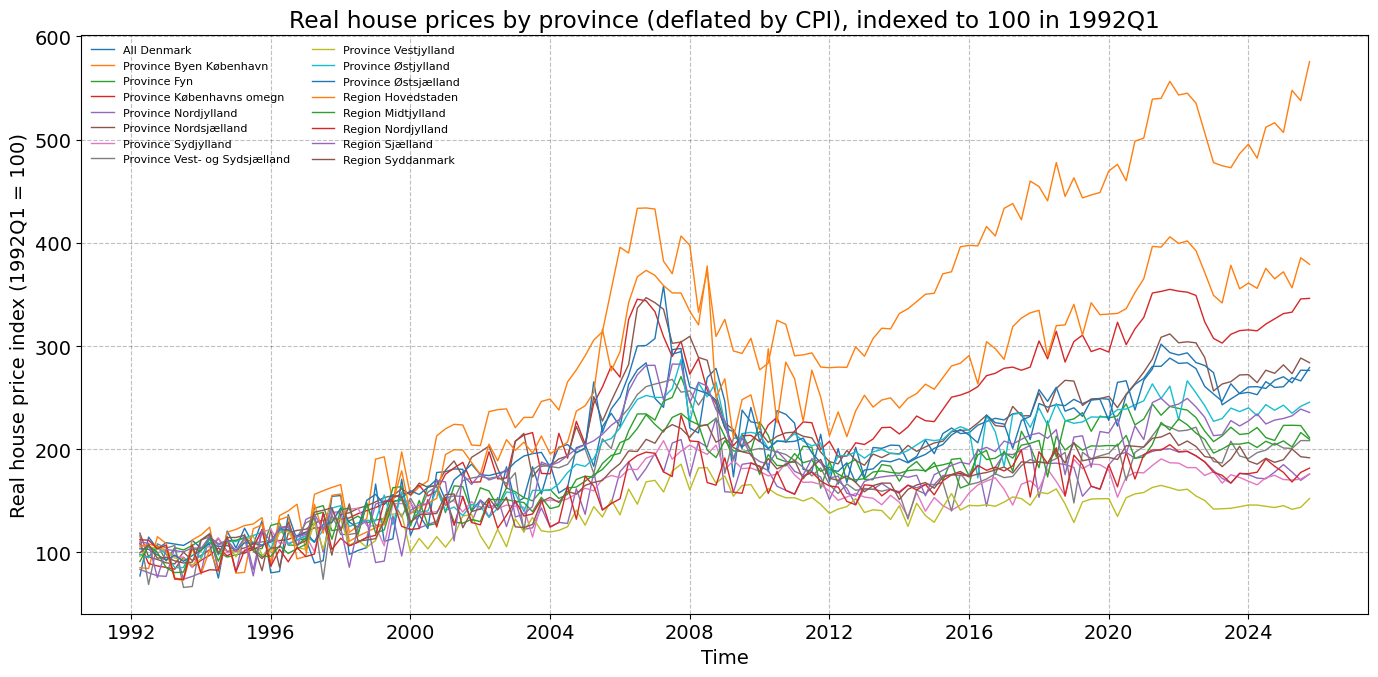

In [168]:
# Likewise we can create a pivot table for the real house prices

wide_real = (HP_real.pivot_table(index='date', columns='OMRÅDE', values='REAL_INDEX_1992', aggfunc='first')
                    .sort_index())

# And drop any provinces with missing data
wide_real = wide_real.dropna(axis=1, how='any')

# And lastly we can plot the real house prices
plt.figure(figsize=(14,7))
for c in wide_real.columns:
    plt.plot(wide_real.index, wide_real[c], linewidth=1)

plt.title('Real house prices by province (deflated by CPI), indexed to 100 in 1992Q1')
plt.xlabel('Time')
plt.ylabel('Real house price index (1992Q1 = 100)')
plt.grid(True, alpha=0.25)
plt.legend(wide_real.columns, ncol=2, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()


In [ ]:
# This figure is very similar to previous one, but we can see that the general levels are lower when adjusting for inflation. 

### 1.3 Question 3

In [169]:
# We must download the data from the provided excel file

filename  = '/Users/bh/Desktop/BM010_houses.xlsx' # Find the exact path to the file
pd.read_excel(filename).iloc[:10,:10]

,"Property prices in the housing market based on prices of realized transactions, property category, area, and time",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Unit: DDK per m^2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1992Q1,1992Q2,1992Q3,1992Q4,1993Q1,1993Q2,1993Q3
2,Realized transaction price,Detached/terraced house,København,5355,5451,5374,5171,5068,5186,5609
3,NaN,NaN,Frederiksberg,5183,5626,6980,6686,5537,7047,6651
4,NaN,NaN,Dragør,6251,6472,6364,6246,6158,6438,6573
5,NaN,NaN,Tårnby,5747,6003,6075,5856,5275,5860,5976
6,NaN,NaN,Albertslund,5240,5408,5417,5341,5130,4773,5746
7,NaN,NaN,Ballerup,5696,6015,5771,5203,5925,5647,5813
8,NaN,NaN,Brøndby,5663,6501,5947,5846,4823,6205,6752
9,NaN,NaN,Gentofte,6783,7378,7288,6860,6692,6840,7348


In [170]:
# Define the data
BM010 = pd.read_excel(filename)


In [171]:
# Name the raw data
raw = pd.read_excel(filename, header=None)

# Extract time periods and convert to string
time = raw.iloc[1, 3:].astype(str).values

# Same with municipalities
municipalities = raw.iloc[2:, 2].astype(str).values

# Extract price data
data = raw.iloc[2:, 3:]

# Clean dataframs
BM010 = pd.DataFrame(data.values, index=municipalities, columns=time)

# Convert missing values ton Nan and then convert to numeric
BM010 = BM010.replace('..', pd.NA)
BM010 = BM010.apply(pd.to_numeric, errors='coerce')


In [172]:
# Drop municipalities with any missing data
BM010_cleaned = BM010.dropna(axis=0, how='any')

In [ ]:
# Next we must plot house price growth across municipalities, against the initial house price level.

# So we define the initial price level and the growth

initial_level = BM010_cleaned.iloc[:, 0]
total_growth = BM010_cleaned.iloc[:, -1] / BM010_cleaned.iloc[:, 0] - 1

analysis = pd.DataFrame({
    'Initial price level': initial_level,
    'Total growth': total_growth
})

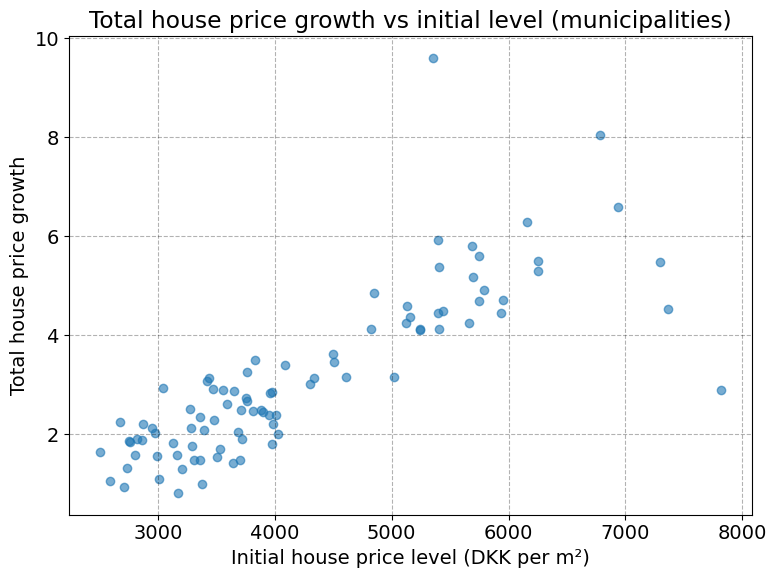

In [174]:
plt.figure(figsize=(8,6))
plt.scatter(
    analysis['Initial price level'],
    analysis['Total growth'],
    alpha=0.6
)

plt.xlabel('Initial house price level (DKK per m²)')
plt.ylabel('Total house price growth')
plt.title('Total house price growth vs initial level (municipalities)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [175]:
# We can examine if there is a correlation between initial price level and growth
corr = analysis['Initial price level'].corr(analysis['Total growth'])
corr

np.float64(0.8135249843570602)

In [179]:
# Based on this correlation, it seems that richer municipalities has experieenced better growth.

# We can then name the municipalities with highest growth and the municipalities with highest initial values
top_growth = analysis.nlargest(5, 'Total growth')
top_initial = analysis.nlargest(5, 'Initial price level')

label_munis = set(top_growth.index).union(set(top_initial.index))

print(label_munis)

{'Gladsaxe', 'Hvidovre', 'Rudersdal', 'København', 'Hørsholm', 'Vallensbæk', 'Gentofte', 'Lyngby-Taarbæk'}


In [177]:
# We here see that there are some overlap, with only 8 unique municipalities in the two top 5 lists.

### 1.4 Question 4

In [180]:
# We want to compute a four-quater backward looking rolling average of house prices per square meter for each municipality.

# this can be done simply, since we already have the data in a DataFrame:
BM010_roll = BM010_cleaned.T.rolling(4).mean().T

# It can seen as each value is given by the average of the current and previous three quarters.
# therefore, first observations will be NaN, since theyre conditionaed on.


In [181]:
# Then we can compute the change in the rolling average from before 2008 (its peak) until the latest available observation.

# We first define the quarters
quarters = pd.PeriodIndex([str(c).replace('K','Q') for c in BM010_roll.columns], freq='Q')

# Create mask for pre-crisis quarters
pre_crisis_mask = quarters <= pd.Period('2008Q2', freq='Q')

# Then we can compute the peak
pre_crisis_peak = BM010_roll.loc[:, pre_crisis_mask].max(axis=1)


In [182]:
# Then we find latest observation
latest = BM010_roll.iloc[:, -1]

# And then compute the percentage change from peak to latest
pct_change = latest - pre_crisis_peak

In [ ]:
# We can also determine which municipalities are still below their pre-crisis peak
still_below_peak = pct_change[pct_change < 0].sort_values()

print("Number of municipalities below peak:", still_below_peak.shape[0])

Number of municipalities below peak: 0


In [ ]:
# This means that none of the municipalities are below their pre-crisis peak in terms of house prices per square meter.
# This is to be expected given the general increase in house prices over the period.

## 2 Exchange Economy

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})


In [127]:
from ExchangeEconomyModel import ExchangeEconomyModelClass
model = ExchangeEconomyModelClass()

par = model.par
sol = model.sol

### 2.1 Question 1

In [ ]:
# We want to plot the two demand curves for each consumer, and then plot excess demand for good 1

# We first define a grid of prices for good 1
p1_grid = np.linspace(0.25, 5.0, 100)

# Then we can compute the demand for each consumer over the price grid
x1A = np.empty_like(p1_grid)
x1B = np.empty_like(p1_grid)
eps1 = np.empty_like(p1_grid)


# And enumate over the price grid to compute demands and excess demand
for i, p1 in enumerate(p1_grid):
    x1A[i], _ = model.demand_A(p1)
    x1B[i], _ = model.demand_B(p1)
    eps1[i], _ = model.check_market_clearing(p1)


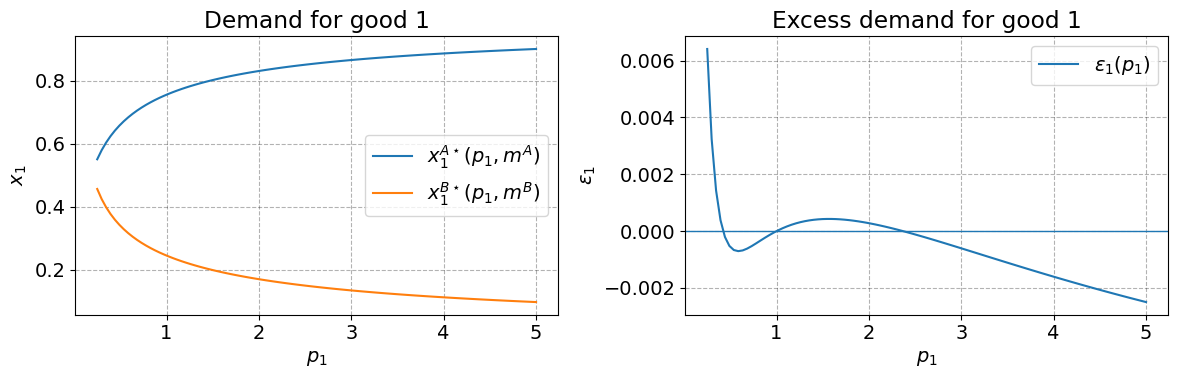

In [ ]:
# We can then plot the figure for the demand curves:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(p1_grid, x1A, label=r"$x_{1}^{A\star}(p_1,m^A)$")
ax[0].plot(p1_grid, x1B, label=r"$x_{1}^{B\star}(p_1,m^B)$")
ax[0].set_title("Demand for good 1")
ax[0].set_xlabel(r"$p_1$")
ax[0].set_ylabel(r"$x_1$")
ax[0].grid(True, alpha=0.3)
ax[0].legend()


# And excess demand for good 1
ax[1].plot(p1_grid, eps1, label=r"$\epsilon_1(p_1)$")
ax[1].axhline(0, linewidth=1)
ax[1].set_title("Excess demand for good 1")
ax[1].set_xlabel(r"$p_1$")
ax[1].set_ylabel(r"$\epsilon_1$")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# then we can determine when epsilon is approx zero:
# We output values where, epsilon is below 0.001 in absolute value
tol = 1e-3
idx_close = np.where(np.abs(eps1) < tol)[0]
print(f"p1 values where |eps1(p1)| < {tol}:")
print(p1_grid[idx_close])

p1 values where |eps1(p1)| < 0.001:
[0.39393939 0.44191919 0.48989899 0.53787879 0.58585859 0.63383838
 0.68181818 0.72979798 0.77777778 0.82575758 0.87373737 0.92171717
 0.96969697 1.01767677 1.06565657 1.11363636 1.16161616 1.20959596
 1.25757576 1.30555556 1.35353535 1.40151515 1.44949495 1.49747475
 1.54545455 1.59343434 1.64141414 1.68939394 1.73737374 1.78535354
 1.83333333 1.88131313 1.92929293 1.97727273 2.02525253 2.07323232
 2.12121212 2.16919192 2.21717172 2.26515152 2.31313131 2.36111111
 2.40909091 2.45707071 2.50505051 2.5530303  2.6010101  2.6489899
 2.6969697  2.74494949 2.79292929 2.84090909 2.88888889 2.93686869
 2.98484848 3.03282828 3.08080808 3.12878788 3.17676768 3.22474747
 3.27272727 3.32070707 3.36868687]


In [25]:
# We can determine the number og equilibria by finding the number of sign changes in eps1

sign_changes = np.where(np.sign(eps1[:-1]) != np.sign(eps1[1:]))[0]

print("\nIntervals with sign changes (equilibrium):")
for i in sign_changes:
    print(f"[{p1_grid[i]:.4f}, {p1_grid[i+1]:.4f}]")

print(f"\nNumber of sign-change intervals (equilibria): {len(sign_changes)}")


Intervals with sign changes (equilibrium):
[0.3939, 0.4419]
[0.9697, 1.0177]
[2.3611, 2.4091]

Number of sign-change intervals (equilibria): 3


In [ ]:
# There are therefore 3 equilibria in this model, which can also be seen from the excess demand plot.

### 2.2 Question 2

In [ ]:
# We want to run a tatonnement algorithm for the given parameter values
# We must first define a Solve_walras class that inherits from the ExchangeEconomyModelClass
# Then we must edit the utility modules, the indifference curves and the market clearing function.

# We can then run the tatonnement algorithm from an initial guess for p1
p_guess = 0.9
model.solve_walras(p_guess=p_guess, print_output=True)

  0: p1 =   0.90000000 -> excess demand good 1 -> -1.82126214e-04, x1A =   0.74188153, x2A =   0.23230662, x1B =   0.25793634, x2B =   0.76785729
  1: p1 =   0.89089369 -> excess demand good 1 -> -2.00078310e-04, x1A =   0.74058113, x2A =   0.23111464, x1B =   0.25921880, x2B =   0.76906361
  2: p1 =   0.88088977 -> excess demand good 1 -> -2.20011247e-04, x1A =   0.73913215, x2A =   0.22979583, x1B =   0.26064784, x2B =   0.77039798
  3: p1 =   0.86988921 -> excess demand good 1 -> -2.42163538e-04, x1A =   0.73751355, x2A =   0.22833413, x1B =   0.26224429, x2B =   0.77187652
  4: p1 =   0.85778103 -> excess demand good 1 -> -2.66796669e-04, x1A =   0.73570053, x2A =   0.22671108, x1B =   0.26403267, x2B =   0.77351778
  5: p1 =   0.84444120 -> excess demand good 1 -> -2.94190793e-04, x1A =   0.73366374, x2A =   0.22490531, x1B =   0.26604207, x2B =   0.77534311
 10: p1 =   0.75395832 -> excess demand good 1 -> -4.81205463e-04, x1A =   0.71864140, x2A =   0.21213266, x1B =   0.2808773

In [48]:
# Then for p_guess = 1.1
p_guess = 1.1
model.solve_walras(p_guess=p_guess, print_output=True)

  0: p1 =   1.10000000 -> excess demand good 1 -> 1.49455089e-04, x1A =   0.76666082, x2A =   0.25667310, x1B =   0.23348864, x2B =   0.74316250
  1: p1 =   1.10747275 -> excess demand good 1 -> 1.59226490e-04, x1A =   0.76746730, x2A =   0.25752363, x1B =   0.23269193, x2B =   0.74230003
  2: p1 =   1.11543408 -> excess demand good 1 -> 1.69422769e-04, x1A =   0.76831842, x2A =   0.25842552, x1B =   0.23185100, x2B =   0.74138550
  3: p1 =   1.12390522 -> excess demand good 1 -> 1.80030146e-04, x1A =   0.76921504, x2A =   0.25938042, x1B =   0.23096499, x2B =   0.74041725
  4: p1 =   1.13290672 -> excess demand good 1 -> 1.91029249e-04, x1A =   0.77015779, x2A =   0.26038979, x1B =   0.23003324, x2B =   0.73939379
  5: p1 =   1.14245819 -> excess demand good 1 -> 2.02394651e-04, x1A =   0.77114705, x2A =   0.26145493, x1B =   0.22905535, x2B =   0.73831385
 10: p1 =   1.19904297 -> excess demand good 1 -> 2.63362695e-04, x1A =   0.77678481, x2A =   0.26764460, x1B =   0.22347856, x2B 

In [ ]:
# Based on the results we can see that good 1 is to cheap for p_guess = 0.9 (excess demand positive) and too expensive for p_guess = 1.1 (excess demand negative).
# Likewise good 2 is too expensive for p_guess = 0.9 (excess demand negative) and too cheap for p_guess = 1.1 (excess demand positive).


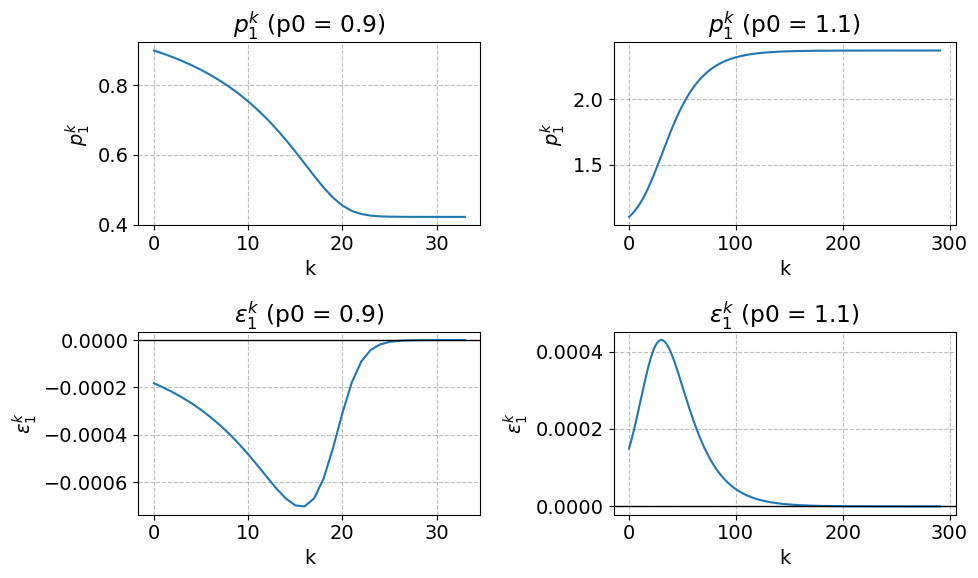

In [ ]:
# We can then plot the figures based on p_path and eps1_path in solve_walrus class for each p_guess
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# p paths
axs[0,0].plot(p_path_09)
axs[0,0].set_title(r"$p_1^k$ (p0 = 0.9)")
axs[0,0].set_xlabel("k")
axs[0,0].set_ylabel(r"$p_1^k$")
axs[0,0].grid(True)

axs[0,1].plot(p_path_11)
axs[0,1].set_title(r"$p_1^k$ (p0 = 1.1)")
axs[0,1].set_xlabel("k")
axs[0,1].set_ylabel(r"$p_1^k$")
axs[0,1].grid(True)

# excess demand paths
axs[1,0].plot(eps_path_09)
axs[1,0].axhline(0, color='black', lw=1)
axs[1,0].set_title(r"$\epsilon_1^k$ (p0 = 0.9)")
axs[1,0].set_xlabel("k")
axs[1,0].set_ylabel(r"$\epsilon_1^k$")
axs[1,0].grid(True)

axs[1,1].plot(eps_path_11)
axs[1,1].axhline(0, color='black', lw=1)
axs[1,1].set_title(r"$\epsilon_1^k$ (p0 = 1.1)")
axs[1,1].set_xlabel("k")
axs[1,1].set_ylabel(r"$\epsilon_1^k$")
axs[1,1].grid(True)

plt.tight_layout()
plt.show()

In [58]:
# these figures show almost opposite paths for p_guess = 0.9 and p_guess = 1.1
# The equilibrium is given where excess demand is approximately zero, which is:
model.solve_walras(p_guess=0.9, print_output=False)
p_star_09 = model.sol.p1

model.solve_walras(p_guess=1.1, print_output=False)
p_star_11 = model.sol.p1

print("Equilibrium from p0=0.9:", p_star_09)
print("Equilibrium from p0=1.1:", p_star_11)


Equilibrium from p0=0.9: 0.42187627669863426
Equilibrium from p0=1.1: 2.3703561473576165


In [ ]:
# This means that the found equilibrium is dependent on the initial guess, and that one equilibrium is missing.

### 2.3 Question 3

In [ ]:
# We want to apply the tatonnement algorithm with the new given linespace for p_0
p0_grid = np.linspace(0.25, 5.0, 50)

p_star = [] # We store the equilibrium prices here

for p0 in p0_grid: # and enumerate over the initial prices
    try:
        model.solve_walras(p_guess=p0, print_output=False) # Run the tatonnement
        p_star.append(model.sol.p1)
    except:
        p_star.append(np.nan) # in case of errors

p_star = np.array(p_star)

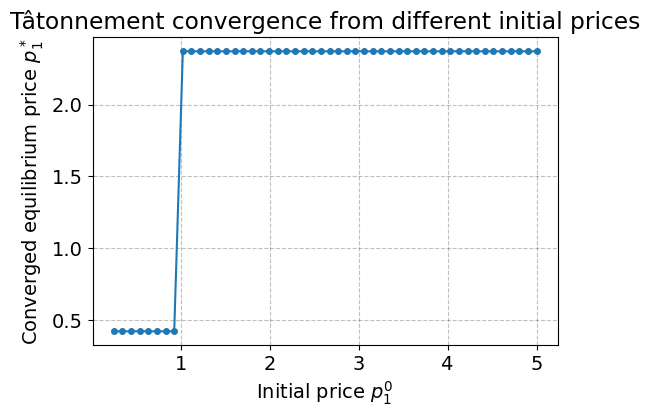

In [62]:
# Then we can plot the results based on the numpy array p_star
plt.figure(figsize=(6,4))
plt.plot(p0_grid, p_star, 'o-', markersize=4)
plt.xlabel(r'Initial price $p_1^0$')
plt.ylabel(r'Converged equilibrium price $p_1^*$')
plt.title('Tâtonnement convergence from different initial prices')
plt.grid(True)
plt.show()

In [ ]:
# So we have equilibrium price on y-axis and and initial price p_0 on x-axis
# The plot show two distinct equilibrium levels, which is equal to the two equilibria we found previously.
# That means that we are still missing one equilibrium.

### 2.4 Question 4

In [ ]:
# For this exercise we wanna run the dampened Newton-Rhapson algorithm for the same linespace
# We do this in the notebook based on the market_clearing function from the ExchangeEconomyModelClass

def Newton_Rhapson(model, p0, tau=1e-8, phi=0.1, iota=0.99, K=5000, h=1e-6): # Define parameters and their values
    p = float(p0)
    for k in range(K+1): # k>K

        eps1, _ = model.check_market_clearing(p)

        if abs(eps1) < tau: # we set up the given steps and restrictions
            return p

        # numerical derivative
        eps1_h, _ = model.check_market_clearing(p + h)
        Delta = (eps1_h - eps1) / h # We compute the difference

        # Newton step (dampened)
        p_new = p - phi * eps1 / Delta # then p^(k+1)

        # restriction for prices to be positive
        if p_new < 0:
            p = iota * p
        else:
            p = p_new

    return np.nan  # did not converge within K


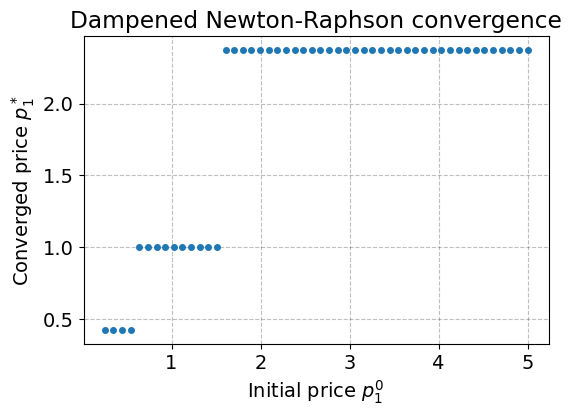

In [68]:
# We can apply for the relevant linespace
p0_grid = np.linspace(0.25, 5.0, 50)
p_star = np.array([Newton_Rhapson(model, p0) for p0 in p0_grid])

# And plot
plt.figure(figsize=(6,4))
plt.plot(p0_grid, p_star, 'o', markersize=4)
plt.xlabel(r'Initial price $p_1^0$')
plt.ylabel(r'Converged price $p_1^*$')
plt.title('Dampened Newton-Raphson convergence')
plt.grid(True)
plt.show()

In [ ]:
# The figure shows the existence of 3 equilibria. We have 0.42 and 2.37 as before, but now we also see the equilibrium at 1
# This means that we are now able to find all equilibria in the model using this method.

### 2.5 Question 5

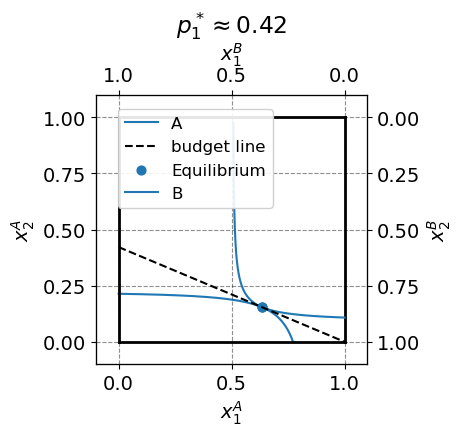

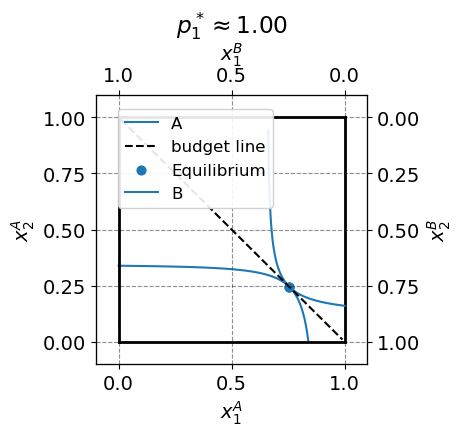

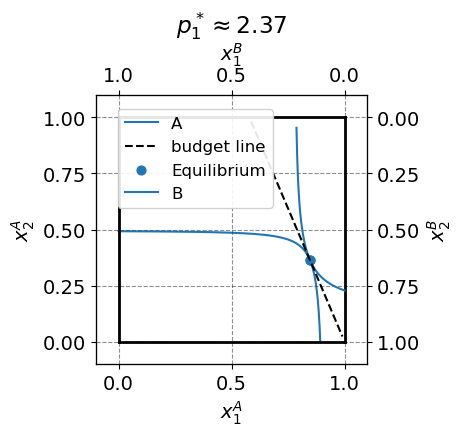

In [ ]:
# We must show each equilibrium in the Edgeworth box

# First we define an array with the equilibrium prices
p_eq = np.unique(np.round(p_star[~np.isnan(p_star)], 4))

# Then we plot them a for loop and the create_edgeworthbox function
for p1_star in p_eq:

    # Equilibrium price
    model.sol.p1 = float(p1_star)

    # equilibrium allocation
    x1A, x2A = model.demand_A(model.sol.p1)
    x1B, x2B = 1 - x1A, 1 - x2A

    # Edgeworth box
    fig, ax_A, ax_B = model.create_edgeworthbox(figsize=(3.5, 3.5))

    # indifference curves
    model.indifference_curve_A(ax_A, x1A, x2A, label='A')
    model.indifference_curve_B(ax_B, x1B, x2B, label='B')

    # budget line
    model.plot_budget_line(ax_A)

    # equilibrium point
    ax_A.scatter(x1A, x2A, s=40, label='Equilibrium')
    ax_B.scatter(x1B, x2B, s=40)

    ax_A.set_title(rf"$p_1^* \approx {model.sol.p1:.2f}$")
    model.add_legend(ax_A, ax_B, bbox_to_anchor=(0.05, 0.55))

    plt.show()

In [ ]:
# From this figure we can the models three equilibriums in each edgeworth box.

## 3 The AS-AD Model

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
from ASADModel import ASADModelClass
model = ASADModelClass()
from matplotlib.lines import Line2D

par = model.par
p = model.par

### 3.1 Question 1

In [ ]:
# We want to create a figure containing the AD-curve, the SRAS-curve for pi^e = pi^* and lastly the the long run equilibrium for pi and y
# We can first define the equilibrium of y and pi which is needed. That is done in the ADASModelClass

# We can then define the demand shock and expected inflation values
v = 0.0                     
pi_e0 = p['pi_star'] # Expected        
pi_e1 = 0.08  # After jump

# The equilibria are then given by;
y0, pi0 = model.equilibrium(pi_e0, v)
y1, pi1 = model.equilibrium(pi_e1, v)


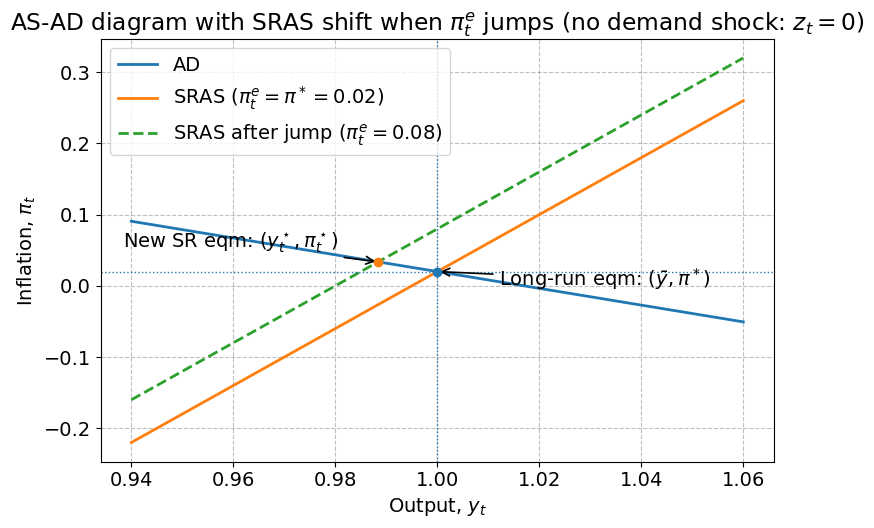

In [ ]:
# We then have what we need to plot the AD and SRAS curves along with the equilibria.

# so we define the grid for y aswell as the curves for each expected inflation value
y_grid = np.linspace(p['ybar'] - 0.06, p['ybar'] + 0.06, 400)
pi_ad = model.AD_curve(y_grid, v=v)
pi_sras0 = model.SRAS_curve(y_grid, pi_e=pi_e0)
pi_sras1 = model.SRAS_curve(y_grid, pi_e=pi_e1)

# Then we can plot the figure
fig, ax = plt.subplots(figsize=(8, 5.5))

ax.plot(y_grid, pi_ad, label="AD", linewidth=2)
ax.plot(y_grid, pi_sras0, label=r"SRAS ($\pi_t^e=\pi^*=0.02$)", linewidth=2)
ax.plot(y_grid, pi_sras1, label=r"SRAS after jump ($\pi_t^e=0.08$)", linewidth=2, linestyle="--")

# long-run equilibrium (pi = pi*, y = ybar)
ax.scatter([p['ybar']], [p['pi_star']], zorder=5)
ax.annotate(r"Long-run eqm: $(\bar y,\pi^*)$",
            xy=(p['ybar'], p['pi_star']),
            xytext=(p['ybar']+0.012, p['pi_star']-0.02),
            arrowprops=dict(arrowstyle="->", lw=1.2))

# new short-run equilibrium after expectations jump
ax.scatter([y1], [pi1], zorder=6)
ax.annotate(r"New SR eqm: $(y_t^\star,\pi_t^\star)$",
            xy=(y1, pi1),
            xytext=(y1-0.05, pi1+0.02),
            arrowprops=dict(arrowstyle="->", lw=1.2))

# reference lines
ax.axvline(p['ybar'], linestyle=":", linewidth=1)
ax.axhline(p['pi_star'], linestyle=":", linewidth=1)

ax.set_xlabel(r"Output, $y_t$")
ax.set_ylabel(r"Inflation, $\pi_t$")
ax.set_title(r"AS-AD diagram with SRAS shift when $\pi_t^e$ jumps (no demand shock: $z_t=0$)")
ax.legend()
ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

In [ ]:
# From this figure we can clearly see the intersection points representing the two equilibria in the AS-AD model.

In [97]:
# we can confirm that the intersection is given by ystar and pistar by solving the equations directly
ad_y1 = model.AD_curve(y1, v=v)
sras1_y1 = model.SRAS_curve(y1, pi_e=pi_e1)
print("No-demand-shock equilibrium:")
print(f"  Initial (pi_e = pi* = {pi_e0:.2f}):  y* = {y0:.6f}, pi* = {pi0:.6f}")
print(f"  After jump (pi_e = {pi_e1:.2f}):      y* = {y1:.6f}, pi* = {pi1:.6f}")


No-demand-shock equilibrium:
  Initial (pi_e = pi* = 0.02):  y* = 1.000000, pi* = 0.020000
  After jump (pi_e = 0.08):      y* = 0.988412, pi* = 0.033648


In [ ]:
# We see from the figure that the intersections are at approximately (1, 0.02) and (0.98, 0.04)
# These values are very close to the computed equilibria values above, which indicates that our plotting and computations are consistent.

### 3.2 Question 2

In [114]:
from ASADModel import ASADModelClass
model = ASADModelClass()
from matplotlib.lines import Line2D

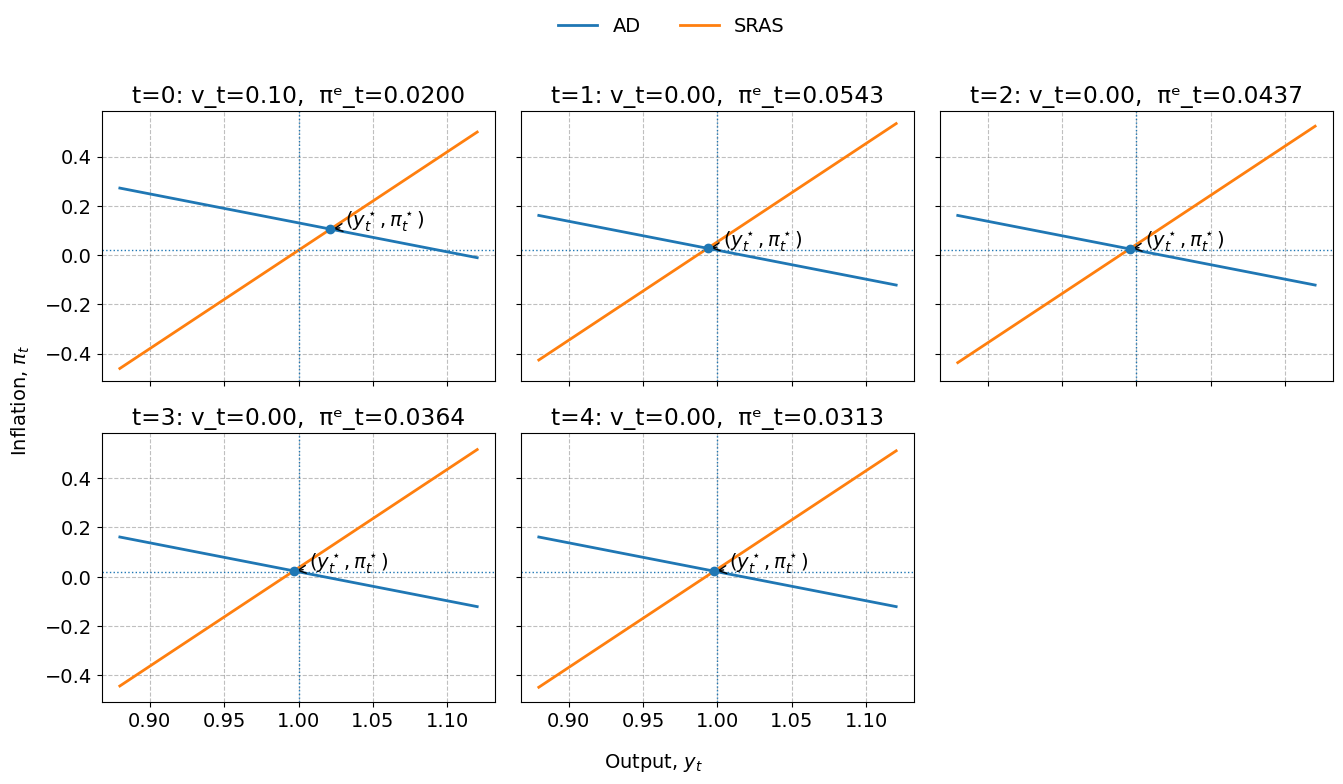

In [ ]:
# To be able to simulate the model we setup a simulation definition, for exactly one demand shock.
# This is given in the ASADModelClass simulate function.
# This simulation function basically sets up the economy and shocks, and then simulates the model over T periods.
# The function also plots the figures

out = model.simulate(T=5, v0=0.1)

In [ ]:
# We here see how both the AD and SRAS curves are affected by the demand shock, since they both contain the y_t - y_bar.
# We also see that, the AD curve, shifts downwards and then stays there, while the SRAS curve shifts up and then gradually moves down as expected inflation adjusts.

### 3.3 Question 3

In [145]:
from ASADModel import ASADModelClass
model = ASADModelClass()
from matplotlib.lines import Line2D

par = model.par
p = model.par

In [121]:
# We want to run the described simulation 500 times
# The new simulation will now assume that the demand shock v_t follows an AR(1) process with rho = 0.8 and sigma = 0.01

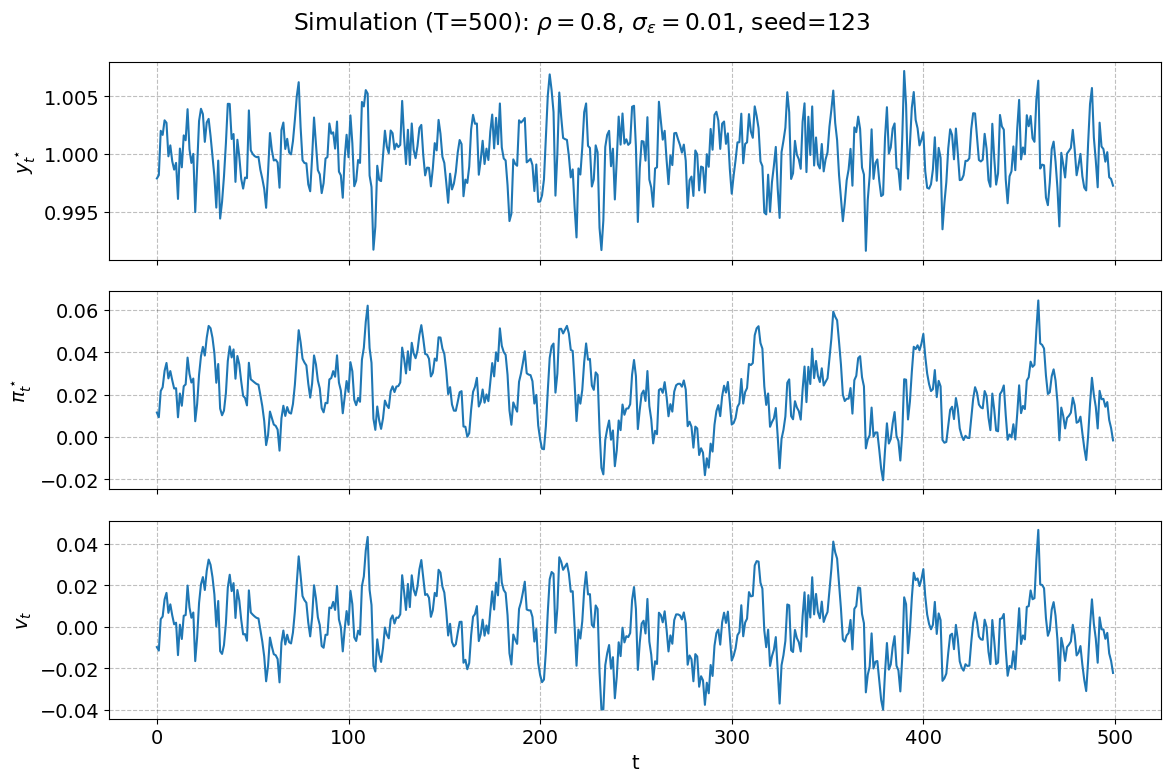

rho = 0.8
  sd(y*)   = 0.002620
  sd(pi*)  = 0.015490
  corr(y*, pi*) = 0.544909


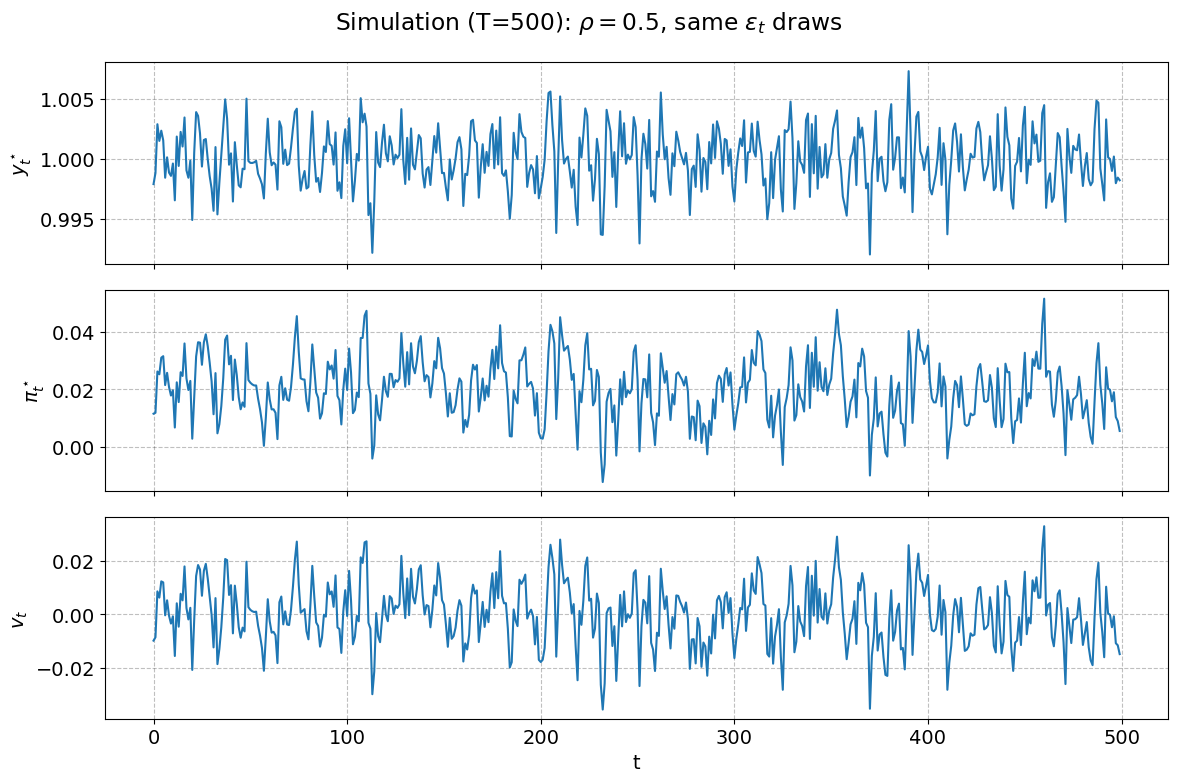


rho = 0.5 (same eps draws)
  sd(y*)   = 0.002399
  sd(pi*)  = 0.010495
  corr(y*, pi*) = 0.734028


In [ ]:
# To simulate this new model we create a new function in the ASADModelClass called simulate_ar1
# This one is similar to the previous simulate function, but now the demand shock is drawn from the AR(1) process.

# We type in the relevant information
T = 500
seed = 123
sigma_eps = 0.01

# Define optimal output and inflation for rho = 0.8 and then computing std and correlation
sim_r08 = model.simulate_ar1(model, T=T, rho=0.8, sigma_eps=sigma_eps, seed=seed)
sd_y_08, sd_pi_08, corr_08 = model.moments(sim_r08["y_star"], sim_r08["pi_star"])

model.plot_series(sim_r08, title=r"Simulation (T=500): $\rho=0.8$, $\sigma_\varepsilon=0.01$, seed=123")

print("rho = 0.8")
print(f"  sd(y*)   = {sd_y_08:.6f}")
print(f"  sd(pi*)  = {sd_pi_08:.6f}")
print(f"  corr(y*, pi*) = {corr_08:.6f}")

# Do the same for rho = 0.5, but using the same epsilon_t draws as before
sim_r05 = model.simulate_ar1(model, T=T, rho=0.5, sigma_eps=sigma_eps, eps=sim_r08["eps"])
sd_y_05, sd_pi_05, corr_05 = model.moments(sim_r05["y_star"], sim_r05["pi_star"])

# We can then plot the results
model.plot_series(sim_r05, title=r"Simulation (T=500): $\rho=0.5$, same $\varepsilon_t$ draws")

print("\nrho = 0.5 (same eps draws)")
print(f"  sd(y*)   = {sd_y_05:.6f}")
print(f"  sd(pi*)  = {sd_pi_05:.6f}")
print(f"  corr(y*, pi*) = {corr_05:.6f}")


In [ ]:
# We see that standard deviation is lower for rho = 0.5, but its correlation is significantly higher.